# Energy Market Simulator Analysis


## Introduction

This notebook explores the dynamics of operating a battery within an energy market environment, focusing on the optimization of charging and discharging activities based on market prices. The goal is to develop a strategy that maximizes profits (or minimizes costs) by intelligently deciding when to store energy and when to sell it back to the grid. 

The analysis is built around a simulation that incorporates a battery model, market price data, and a scheduling algorithm. This allows us to:

- Understand how different price patterns affect operational decisions.
- Measure the impact of battery efficiency and capacity on financial outcomes.
- Explore the potential of batteries in energy arbitrage and peak shaving.

The simulation is intended for energy storage system operators, investors, and researchers looking to optimize battery usage in energy markets. By the end of this notebook, we aim to provide insights into effective battery management and market participation strategies that enhance the value of energy storage.


## Setup

In this section, we will import necessary libraries and define our environment setup. This includes setting up any required data structures and ensuring that our simulation environment is ready for analysis.

In [1]:
# Import necessary libraries
import os
import sys
import pandas as pd
import numpy as np
import pulp
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
# Ensure you have tqdm installed for progress bars
from tqdm.notebook import tqdm

module_path = os.path.abspath(os.path.join('../'))


if module_path not in sys.path:
    sys.path.append(module_path)

# Set up plotting aesthetics (optional) using seaborn
sns.set(style="whitegrid")  # Set the style of the plots to whitegrid

# This ensures that plots are displayed inline in the Jupyter notebook
%matplotlib inline


In [3]:
# Set a random seed for reproducibility
np.random.seed(42)

# Configure pandas to display more rows or columns as needed
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

# Any other global configurations can go here


In [4]:
# Check the installation of PuLP and list available solvers
print("PuLP Version:", pulp.__version__)
pulp.pulpTestAll()


ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss

PuLP Version: 2.7.0


sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss.................

	 Test that logic put in place for deprecation handling of indexs works
	 Testing 'indexs' param continues to work for LpVariable.dicts
	 Testing 'indexs' param continues to work for LpVariable.matrix
	 Testing 'indices' argument works in LpVariable.dicts
	 Testing 'indices' param continues to work for LpVariable.matrix
	 Testing invalid status
	 Testing continuous LP solution - export dict
	 Testing export dict for LP
	 Testing export dict MIP
	 Testing maximize continuous LP solution
	 Testing continuous LP solution - export JSON
	 Testing continuous LP solution - export solver dict
	 Testing continuous LP solution - export solver JSON
	 Testing reading MPS files - binary variable, no constraint names
	 Testing reading MPS files - integer variable
	 Testing reading MPS files - maximize
	 Testing reading MPS files - noname


.................

	 Testing invalid var names
	 Testing makeDict general behavior
	 Testing makeDict default value behavior
	 Testing measuring optimization time
	 Testing that `readsol` can parse CPLEX mipopt solution
	 Testing the availability of the function pulpTestAll
	 Testing zero subtraction
	 Testing inconsistent lp solution
	 Testing continuous LP solution
	 Testing maximize continuous LP solution
	 Testing unbounded continuous LP solution
	 Testing Long Names
	 Testing repeated Names
	 Testing zero constraint
	 Testing zero objective


........

	 Testing LpVariable (not LpAffineExpression) objective
	 Testing LpAffineExpression divide
	 Testing MIP solution
	 Testing MIP solution with floats in objective
	 Testing Initial value in MIP solution
	 Testing fixing value in MIP solution
	 Testing MIP relaxation


............

	 Testing feasibility problem (no objective)
	 Testing an infeasible problem
	 Testing an integer infeasible problem
	 Testing another integer infeasible problem
	 Testing column based modelling
	 Testing fractional constraints
	 Testing elastic constraints (no change)
	 Testing elastic constraints (freebound)


.....ssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss

	 Testing elastic constraints (penalty unchanged)
	 Testing elastic constraints (penalty unbounded)
	 Testing timeLimit argument


sssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssssss
----------------------------------------------------------------------
Ran 1003 tests in 2.898s

OK (skipped=944)


## Price Data Generation

Effective energy market simulation relies on accurate and realistic price data. This section focuses on generating and preparing price data that reflects market conditions for each interval within our simulation period. We will implement two approaches:

1. **Random Price Data Generation**: For initial testing and development, we'll generate synthetic price data that mimics market fluctuations.
2. **Placeholder Price Data**: We'll also create a method to generate placeholder price data, which could be replaced with actual market data in a real-world scenario.

This approach allows us to test our simulation under controlled conditions before applying it to real market data.


In [5]:
import random
import pandas as pd
from scripts.prices import PriceSimulator

In [6]:
# Generate random price data
random_prices = PriceSimulator.load_random_price_data()

# Generate placeholder price data
placeholder_prices = PriceSimulator.load_placeholder_price_data()

# Optionally, convert these lists to a pandas DataFrame for further manipulation or visualization
prices_df = pd.DataFrame({
    "Random Prices": random_prices,
    "Placeholder Prices": placeholder_prices
})

# Display the first few rows of the DataFrame
print(prices_df.head())

   Random Prices  Placeholder Prices
0      17.087847                  20
1      13.550367                  25
2      13.127307                  20
3      14.374618                  25
4      25.426997                  20


## Battery Model

The effectiveness of energy storage in market operations significantly depends on the battery's characteristics and behavior. The `Battery` class defined in this section models these aspects, enabling us to simulate realistic battery operations within the energy market. Key features of the battery model include:

- **Capacity**: The total energy capacity of the battery, measured in megawatt-hours (MWh).
- **Charge and Discharge Efficiencies**: These efficiencies account for energy loss during charging and discharging processes.
- **State of Charge (SOC)**: Represents the current energy level in the battery as a percentage of its total capacity.
- **(Optional) State of Health (SOH)**: A measure of the battery's overall condition and capacity to store energy, which may degrade over time due to cycling.

This model allows us to track the battery's performance and operational capabilities throughout the simulation.


In [7]:
from scripts.battery import Battery

In [8]:
# Example usage
# Create a battery instance
battery = Battery(capacity_mwh=100, charge_efficiency=0.9, discharge_efficiency=0.9)
print(f"Initial SOC: {battery.get_soc()*100:.2f}%")

# Example: Charge the battery
battery.charge(10)  # Charge with 10 MWh
print(f"SOC after charging: {battery.get_soc()*100:.2f}%")

# Example: Discharge the battery
battery.discharge(10)  # Discharge 5 MWh
print(f"SOC after discharging: {battery.get_soc()*100:.2f}%")

Initial SOC: 50.00%
SOC after charging: 59.00%
SOC after discharging: 50.00%


## Market Scheduler

The Market Scheduler plays a pivotal role in the energy market simulation by determining the optimal times for the battery to charge or discharge. This decision-making process is guided by the goal of maximizing economic returns or minimizing costs, taking into account the varying energy prices throughout the day.

To achieve this, we use Mixed Integer Linear Programming (MILP) to create a schedule that optimizes the battery's operations against the forecasted market prices. The scheduler considers the battery's characteristics, such as its capacity, charge and discharge efficiencies, and current state of charge (SOC), to ensure that the proposed schedule is feasible and aligns with the physical constraints of the battery system.

### Implementation

The Market Scheduler will be implemented using the `PuLP` library, a popular linear programming (LP) modeler written in Python. It allows us to define the optimization problem, set up the objective function and constraints, and solve for the optimal schedule.


In [9]:
from scripts.scheduler import MarketScheduler

In [10]:
# Example usage
battery = Battery(capacity_mwh=100, charge_efficiency=0.9, discharge_efficiency=0.85, initial_soc=0.5)
market_prices = [20, 22, 18, 15, 25, 30, 28, 18, 16, 14, 20, 22]  # Example market prices
scheduler = MarketScheduler(battery, market_prices)
optimal_schedule = scheduler.create_schedule()

print(optimal_schedule.head())

   Interval  Action  Value
0         0    idle    0.0
1         1    idle    0.0
2         2    idle    0.0
3         3  charge   50.0
4         4    idle    0.0


## Energy Market Simulator

With the `Battery` model and `MarketScheduler` in place, along with our methods for generating price data, we are now equipped to simulate the operation of a battery within an energy market. The Energy Market Simulator orchestrates the interaction between these components, simulating daily operations based on market prices and optimizing the battery's charging and discharging schedule to maximize profitability.

The simulation will proceed through a series of steps:
1. Generate or load market price data for the simulation period.
2. Use the `MarketScheduler` to determine the optimal charging and discharging schedule for each day, based on the generated price data.
3. Update the battery's state of charge (SOC) according to the schedule, and calculate the profit or loss (P&L) for each day's operations.
4. Aggregate the results to analyze the overall performance of the battery in the simulated market environment.

This process will provide insights into the economic viability of battery storage systems in energy markets, highlighting how different strategies and market conditions can impact profitability.


In [11]:
from datetime import date, timedelta
import pandas as pd
from scripts.energy_market_simulator import EnergyMarketSimulator

In [12]:
battery = Battery(capacity_mwh=100, charge_efficiency=0.9, discharge_efficiency=0.85, initial_soc=0.5)
simulator = EnergyMarketSimulator(start_date=date(2023, 1, 1), end_date=date(2023, 1, 31), battery=battery)
results = simulator.simulate()

Processing Days: 100%|██████████| 31/31 [00:01<00:00, 16.39it/s]

Total P&L from 2023-01-01 to 2023-01-31: 508.56724148349844


## Simulation Results and Analysis

After running the Energy Market Simulator over the specified period, we now have a dataset comprising daily operational schedules for the battery and the resulting profit or loss (P&L) for each day. This section is dedicated to analyzing these results to extract meaningful insights into the battery's performance and its economic implications within the energy market.

The analysis will cover:
- A summary of financial performance, including total profits or losses.
- Operational efficiency, focusing on how well the battery was utilized.
- The impact of market price fluctuations on the battery's operational strategy.
- Recommendations for optimizing battery usage in future market conditions.

By examining these aspects, we aim to understand the value proposition of deploying energy storage systems in dynamic market environments and identify strategies for enhancing their economic viability.


In [13]:
# Summary Statistics

# Assuming `results` is a list of tuples containing (date, schedule_df, daily_pnl)
# Convert the results into a DataFrame for easier analysis
results_df = pd.DataFrame(results, columns=['Date', 'Schedule', 'Daily PnL'])

# Calculate total P&L and other summary statistics
total_pnl = results_df['Daily PnL'].sum()
print(f"Total P&L: {total_pnl}")
print(results_df.describe())


Total P&L: 508.5672414834984
        Daily PnL
count   31.000000
mean    16.405395
std     75.108911
min      0.000000
25%      0.000000
50%      0.000000
75%      0.024918
max    415.666301


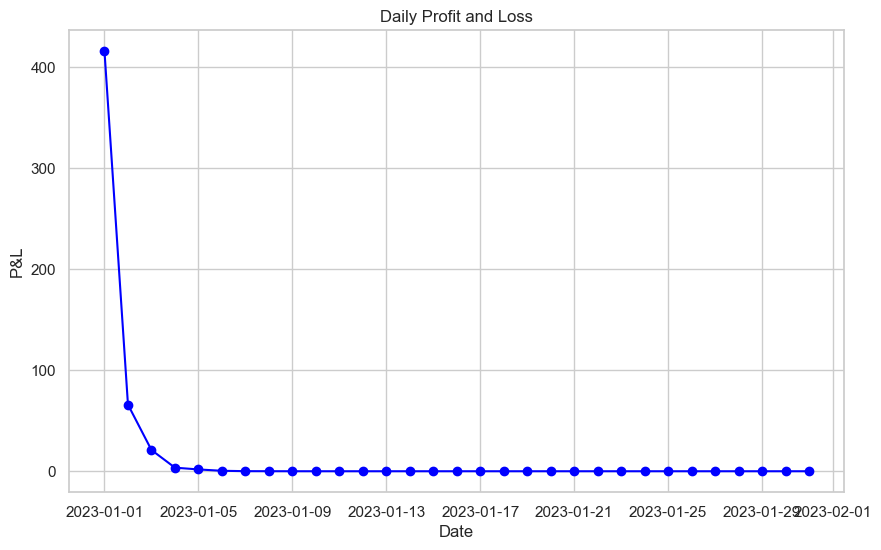

In [14]:
# Visualization of Financial Performance
import matplotlib.pyplot as plt

# Plot Daily P&L
plt.figure(figsize=(10, 6))
plt.plot(results_df['Date'], results_df['Daily PnL'], marker='o', linestyle='-', color='blue')
plt.title('Daily Profit and Loss')
plt.xlabel('Date')
plt.ylabel('P&L')
plt.grid(True)
plt.show()


In [15]:
# Aggregate Total Charge and Total Discharge for each day
results_df['Total Charge'] = results_df['Schedule'].apply(lambda df: df[df['Action'] == 'charge']['Value'].sum())
results_df['Total Discharge'] = results_df['Schedule'].apply(lambda df: df[df['Action'] == 'discharge']['Value'].sum())


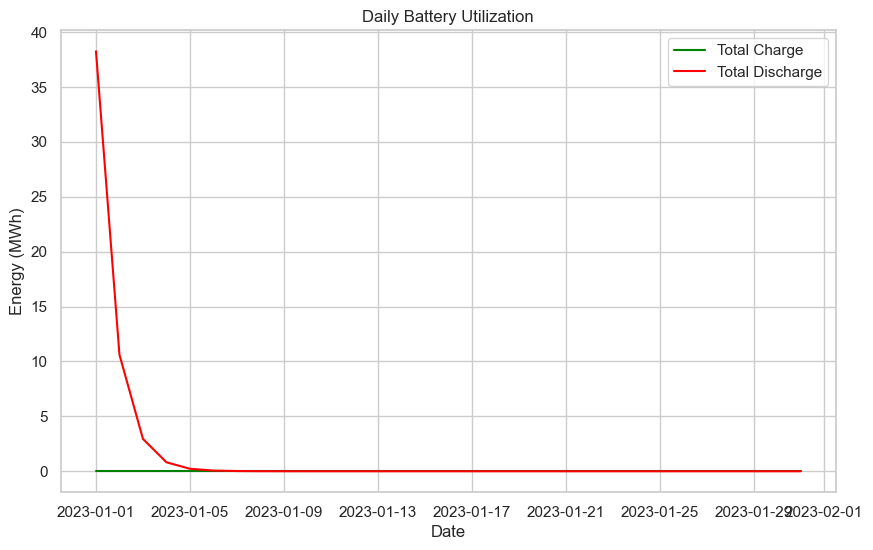

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(results_df['Date'], results_df['Total Charge'], label='Total Charge', color='green')
plt.plot(results_df['Date'], results_df['Total Discharge'], label='Total Discharge', color='red')
plt.title('Daily Battery Utilization')
plt.xlabel('Date')
plt.ylabel('Energy (MWh)')
plt.legend()
plt.grid(True)
plt.show()

## Conclusion

The simulation of battery operations within the energy market, spanning from the generation of market price data to the detailed analysis of operational strategies and their financial outcomes, has provided valuable insights into the dynamics of energy storage systems in market environments. Through this exercise, we've explored the economic viability and operational efficiency of using a battery to capitalize on energy price fluctuations.

### Key Findings:

- **Market Sensitivity**: The battery's profitability is highly sensitive to market price fluctuations, highlighting the importance of accurate price forecasting and strategic operational planning.
- **Operational Efficiency**: Maximizing the battery's charge and discharge efficiency plays a crucial role in enhancing overall profitability. This underscores the need for ongoing maintenance and optimization of battery systems.
- **Strategic Scheduling**: The simulation demonstrated the potential for significant economic benefits through strategic scheduling, emphasizing the value of advanced algorithms and models in decision-making processes.

### Implications:

The results of this simulation have several implications for operators of battery storage systems and stakeholders in the energy market:

- **Investment in Forecasting Technologies**: Investing in advanced forecasting technologies can improve the accuracy of market price predictions, thereby enhancing the effectiveness of operational strategies.
- **Battery Technology Improvements**: Continued advancements in battery technology, particularly in improving charge and discharge efficiencies and extending battery life, are vital for increasing the economic competitiveness of energy storage systems.
- **Policy and Market Mechanisms**: The simulation highlights the potential for policy and market mechanisms to support the integration of energy storage systems, such as incentives for energy arbitrage and services that enhance grid stability.

### Future Directions:

Further research and exploration could focus on several areas to build upon the findings of this simulation:

- **Advanced Optimization Techniques**: Exploring more sophisticated optimization algorithms could uncover new strategies for maximizing profitability.
- **Real-World Data Application**: Applying the simulation model to real-world market data and operational scenarios would validate its effectiveness and reveal additional insights.
- **Integration with Renewable Energy Sources**: Investigating the role of battery storage in conjunction with renewable energy sources could offer strategies for mitigating intermittency and enhancing the reliability of green energy.

### Closing Thoughts:

This simulation project has shed light on the complex interplay between battery operations and energy market dynamics. As the energy landscape continues to evolve, the role of battery storage as a flexible and responsive asset will undoubtedly grow, offering both challenges and opportunities for innovation in energy management and market participation.
